### KNN

En este notebook utilizaremos modelos de KNN para entrenar y clasificar el dataset con distintas configuraciones. Comenzaremos con la función de preprocesamiento que recrea lo realizado en la primera parte del TP, continuaremos con la función `preprocessing_significantes`, y finalizaremos preprocesando con las mejores variables seleccionadas con un árbol de decisión.

In [1]:
# Modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing
import preprocessing
import utils

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

Definimos los hiperparámetros que probaremos y sus valores posibles, para la validación cruzada.

In [2]:
params = [
    {'algorithm': ['ball_tree', 'kd_tree'],
         'n_neighbors': range(5, 150,5),
         'weights': ('uniform', 'distance'),
         'p': [1,2]},
    {'algorithm': ['brute'],
         'n_neighbors': range(5, 150, 10), 
         'weights': ('uniform', 'distance'),
         'p': [1,2]}
]
model = KNeighborsClassifier()

### Preprocessing base

Comenzamos por entrenar un modelo de KNN bajo las mismas condiciones en las que realizamos el baseline de la primera parte del TP, con la salvedad de que estandarizaremos las variables.

In [3]:
df_base = utils.get_data()

In [4]:
gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [5]:
X = df_base.drop('tiene_alto_valor_adquisitivo',1)
Y = df_base['tiene_alto_valor_adquisitivo']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X,
                                                                        Y,
                                                                        stratify=Y,
                                                                        random_state=112)
X_train_base, X_test_base = preprocessing.standard_preprocessing_base_parte_1(X_train_base, X_test_base)

In [6]:
%%time
gscv_base.fit(X_train_base, y_train_base)

Fitting 4 folds for each of 292 candidates, totalling 1168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1168 out of 1168 | elapsed: 13.1min finished


CPU times: user 6.5 s, sys: 422 ms, total: 6.92 s
Wall time: 13min 5s


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree'],
                          'n_neighbors': range(5, 150, 5), 'p': [1, 2],
                          'weights': ('uniform', 'distance')},
                         {'algorithm': ['brute'],
                          'n_neighbors': range(5, 150, 10), 'p': [1, 2],
                          'weights': ('uniform', 'distance')}],
             scoring='roc_auc', verbose=5)

In [7]:
score_base = roc_auc_score(y_test_base, gscv_base.predict_proba(X_test_base)[:,1])

In [8]:
gscv_base.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 85, 'p': 2, 'weights': 'uniform'}

In [9]:
knn1 = gscv_base.best_estimator_
knn1.fit(X_train_base, y_train_base)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=85)

In [10]:
score_base

0.8949785633392655

Vemos un buen resultado en AUC-ROC, veamos cómo dieron las demás métricas

In [11]:
print(classification_report(y_test_base,gscv_base.predict(X_test_base), digits=4))

              precision    recall  f1-score   support

           0     0.8679    0.9335    0.8995      6181
           1     0.7247    0.5520    0.6267      1960

    accuracy                         0.8417      8141
   macro avg     0.7963    0.7428    0.7631      8141
weighted avg     0.8335    0.8417    0.8338      8141



En líneas generales son buenos resultados, con un accuracy equiparable al de la parte 1 de este TP. Lo que sigue siendo bastante pobre es la clasificación de casos de poder adquisitivo alto.

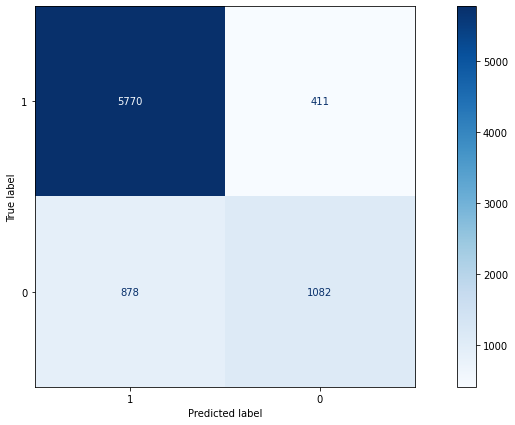

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_base, X_test_base, y_test_base, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

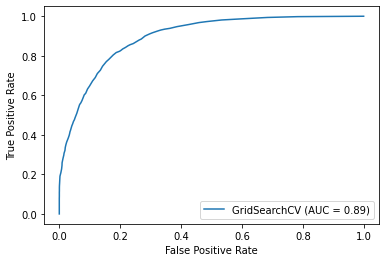

In [13]:
plot_roc_curve(gscv_base, X_test_base, y_test_base)

En general, podemos decir que es un buen clasificador. Veamos si podemos obtener mejores resultados trabajando de forma distinta con el preprocesamiento de los datos.

### Preprocessing Significantes

Repetimos el procedimiento anterior, con otro preprocesamiento.

In [14]:
df = utils.get_data()

In [15]:
params = [
    {'algorithm': ['ball_tree', 'kd_tree'],
         'n_neighbors': range(5, 150, 5),
         'weights': ('uniform', 'distance'),
         'p': [1,2]},
    {'algorithm': ['brute'],
         'n_neighbors': range(5, 150, 10), 
         'weights': ('uniform', 'distance'),
         'p': [1,2]}
]
model = KNeighborsClassifier()

In [16]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=2, verbose=5)

In [17]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=112)
X_train, X_test = preprocessing.preprocessing_significantes(X_train, X_test, 0.9)

/home/nicolascontinanza/Desktop/tpdatos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/tpdatos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['gananci

In [18]:
%%time
gscv.fit(X_train, y_train)

Fitting 2 folds for each of 292 candidates, totalling 584 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done 584 out of 584 | elapsed: 83.7min finished


CPU times: user 3.4 s, sys: 280 ms, total: 3.68 s
Wall time: 1h 23min 40s


GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree'],
                          'n_neighbors': range(5, 150, 5), 'p': [1, 2],
                          'weights': ('uniform', 'distance')},
                         {'algorithm': ['brute'],
                          'n_neighbors': range(5, 150, 10), 'p': [1, 2],
                          'weights': ('uniform', 'distance')}],
             scoring='roc_auc', verbose=5)

In [19]:
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

In [20]:
gscv.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}

In [21]:
knn2 = gscv.best_estimator_
knn2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=30)

In [22]:
score

0.8809244673439672

Hay un ligero empeoramiento en la métrica AUC-ROC

In [23]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6181
           1       0.70      0.55      0.61      1960

    accuracy                           0.83      8141
   macro avg       0.78      0.74      0.75      8141
weighted avg       0.82      0.83      0.83      8141



Vemos que en el resto de las métricas los resultados tampoco mejoraron, y algunos de ellos empeoraron. 

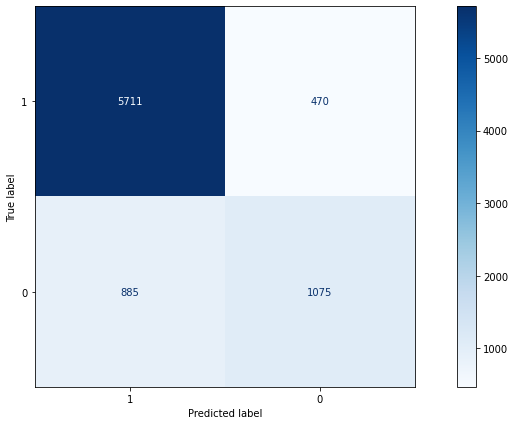

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

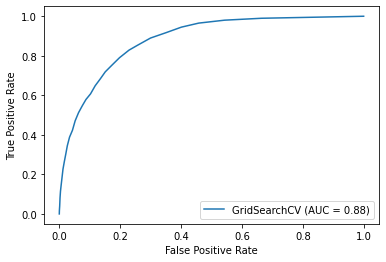

In [25]:
plot_roc_curve(gscv, X_test, y_test)

Vemos que los resultados, si bien no son pésimos, empeoraron respecto del primer caso. Continuemos con el último preprocesamiento que usaremos en este modelo.  

### Mejores variables seleccionadas con un arbol

En línea con lo analizado en el notebook de análisis de preprocessings, entrenaremos un modelo de KNN con las variables seleccionadas usando un árbol de decisión.

In [26]:
df = utils.get_data()

In [27]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=112)

In [28]:
X_train, X_test = preprocessing.standard_preprocessing_mejores_por_arbol(X_train, X_test)

In [29]:
params = [
    {'algorithm': ['ball_tree', 'kd_tree'],
         'n_neighbors': range(5, 150, 5),
         'weights': ('uniform', 'distance'),
         'p': [1,2]},
    {'algorithm': ['brute'],
         'n_neighbors': range(5, 150, 10), 
         'weights': ('uniform', 'distance'),
         'p': [1,2]}
]

model = KNeighborsClassifier()

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=2, verbose = 4)

In [30]:
%%time
gscv1.fit(X_train, y_train)

Fitting 2 folds for each of 292 candidates, totalling 584 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 584 out of 584 | elapsed: 10.6min finished


CPU times: user 3.25 s, sys: 267 ms, total: 3.52 s
Wall time: 10min 34s


GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree'],
                          'n_neighbors': range(5, 150, 5), 'p': [1, 2],
                          'weights': ('uniform', 'distance')},
                         {'algorithm': ['brute'],
                          'n_neighbors': range(5, 150, 10), 'p': [1, 2],
                          'weights': ('uniform', 'distance')}],
             scoring='roc_auc', verbose=4)

#### El mejor modelo:

In [31]:
print(gscv1.best_estimator_)
print(gscv1.best_params_)
print(gscv1.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=40)
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}
0.8938770580348361


Obtuvimos un modelo bastante similar al anterior, por lo que no sería esperable que haya una mejora considerable en las métricas que nos interesa analizar.

In [32]:
knn3 = gscv1.best_estimator_
knn3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=40)

In [33]:
print(classification_report(y_test,gscv1.predict(X_test),digits=4))

              precision    recall  f1-score   support

           0     0.8635    0.9377    0.8991      6181
           1     0.7306    0.5327    0.6161      1960

    accuracy                         0.8402      8141
   macro avg     0.7971    0.7352    0.7576      8141
weighted avg     0.8315    0.8402    0.8310      8141



Efectivamente, obtuvimos resultados que no difieren en gran medida de lo obtenido anteriormente. 

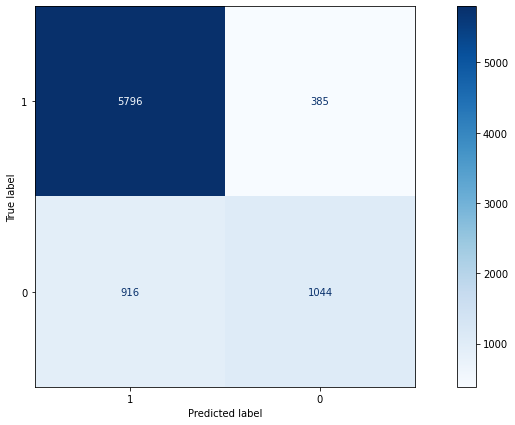

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv1, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

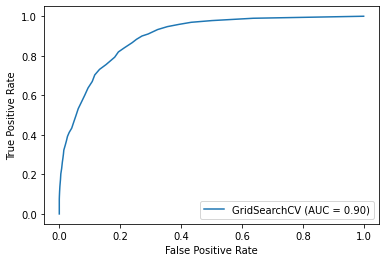

In [35]:
plot_roc_curve(gscv1, X_test, y_test)

Vemos que, de los tres modelos entrenados, el último es el que mejores resultados tuvo, si bien esos resultados no distan en gran medida de los demás. Podemos atribuirle esta mejora en los resultados a la selección de variables realizada en el preprocesamiento.

# Persistiendo los modelos

In [36]:
import pickle

In [38]:
pickle.dump(knn1, open("Modelos/KNN/knn1.pickle", "wb"))
pickle.dump(knn2, open("Modelos/KNN/knn2.pickle", "wb"))
pickle.dump(knn3, open("Modelos/KNN/knn3.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el KNN obtenido para el preprocessing mejores variables según tree.

In [39]:
knn3 = pickle.load(open("Modelos/KNN/knn3.pickle", "rb"))

In [40]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv)
    

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X)

    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    Xv, X = preprocessing.standard_preprocessing_mejores_por_arbol(Xv, X)
    return ids, X

In [41]:
ids, X = holdout()

In [42]:
utils.escribir_holdout(knn3.predict(X), "2 - KNN", ids)